# Importing Libraries

In [14]:
import ase.io # for reading *.xyz
import numpy as np
import pandas as pd # for dataframes
from pandas import options
import matplotlib.pyplot as plt # for plotting error distribution
from matplotlib.colors import Normalize, LogNorm, to_hex
from matplotlib.cm import (
    plasma,
    inferno,
    magma,
    viridis,
    cividis,
    turbo,
    ScalarMappable,
)
from bokeh.models import (
    ColumnDataSource,
    LinearColorMapper,
    LogColorMapper,
    ColorBar,
    BasicTicker,
)
from bokeh.plotting import figure, output_notebook
from bokeh.io import show
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge
from typing import List
import warnings

# Setting Variables and Functions

In [15]:
DATASET_LOCATION = "../data_structures_errors_head_100.xyz" # should be in the same directory as the repository
FIGURE_SIZE_X = 20
FIGURE_SIZE_Y = FIGURE_SIZE_X/2

In [16]:
def ptable_plotter( # adapted from https://github.com/arosen93/ptable_trends
    data_elements: List[str],
    data_list: List[float],
    width: int = 1050,
    cmap: str = "plasma",
    alpha: float = 0.65,
    periods_remove: List[int] = None,
    groups_remove: List[int] = None,
    log_scale: bool = False,
    cbar_height: float = None,
    cbar_standoff: int = 12,
    cbar_fontsize: int = 14,
    blank_color: str = "#c4c4c4",
    under_value: float = None,
    under_color: str = "#140F0E",
    over_value: float = None,
    over_color: str = "#140F0E",
    special_elements: List[str] = None,
    special_color: str = "#6F3023",
) -> figure: 

    """
    Plot a heatmap over the periodic table of elements.

    Parameters
    ----------
    filename : str
        Path to the .csv file containing the data to be plotted.
    show : str
        If True, the plot will be shown.
    width : float
        Width of the plot.
    cmap : str
        plasma, inferno, viridis, magma, cividis, turbo
    alpha : float
        Alpha value (transparency).
    periods_remove : List[int]
        Period numbers to be removed from the plot.
    groups_remove : List[int]
        Group numbers to be removed from the plot.
    log_scale : bool
        If True, the colorbar will be logarithmic.
    cbar_height : int
        Height of the colorbar.
    cbar_standoff : int
        Distance between the colorbar and the plot.
    cbar_fontsize : int
        Fontsize of the colorbar label.
    blank_color : str
        Hexadecimal color of the elements without data.
    under_value : float
        Values <= under_value will be colored with under_color.
    under_color : str
        Hexadecimal color to be used for the lower bound color.
    over_value : float
        Values >= over_value will be colored with over_color.
    under_color : str
        Hexadecial color to be used for the upper bound color.
    special_elements: List[str]
        List of elements to be colored with special_color.
    special_color: str
        Hexadecimal color to be used for the special elements.

    Returns
    -------
    figure
        Bokeh figure object.
    """

    # Assign color palette based on input argument
    if cmap == "plasma":
        cmap = plasma
        bokeh_palette = "Plasma256"
    elif cmap == "inferno":
        cmap = inferno
        bokeh_palette = "Inferno256"
    elif cmap == "magma":
        cmap = magma
        bokeh_palette = "Magma256"
    elif cmap == "viridis":
        cmap = viridis
        bokeh_palette = "Viridis256"
    elif cmap == "cividis":
        cmap = cividis
        bokeh_palette = "Cividis256"
    elif cmap == "turbo":
        cmap = turbo
        bokeh_palette = "Turbo256"
    else:
        ValueError("Invalid color map.")

    # Define number of and groups
    period_label = ["1", "2", "3", "4", "5", "6", "7"]
    group_range = [str(x) for x in range(1, 19)]

    if len(data_list) != len(data_elements):
        raise ValueError("Unequal number of atomic elements and data points")

    period_label.append("blank")

    # Define matplotlib and bokeh color map
    if log_scale:
        for datum in data_list:
            if datum < 0:
                raise ValueError(
                    f"Entry for element {datum} is negative but log-scale is selected"
                )
        color_mapper = LogColorMapper(
            palette=bokeh_palette, low=min(data_list), high=max(data_list)
        )
        norm = LogNorm(vmin=min(data_list), vmax=max(data_list))
    else:
        color_mapper = LinearColorMapper(
            palette=bokeh_palette, low=min(data_list), high=max(data_list)
        )
        norm = Normalize(vmin=min(data_list), vmax=max(data_list))
    color_scale = ScalarMappable(norm=norm, cmap=cmap).to_rgba(data_list, alpha=None)

    # Set blank color
    color_list = [blank_color] * len(elements)

    # Compare elements in dataset with elements in periodic table
    for i, data_element in enumerate(data_elements):
        element_entry = elements.symbol[
            elements.symbol.str.lower() == data_element.lower()
        ]
        if element_entry.empty == False:
            element_index = element_entry.index[0]
        else:
            warnings.warn("Invalid chemical symbol: " + data_element)
        if color_list[element_index] != blank_color:
            warnings.warn("Multiple entries for element " + data_element)
        elif under_value is not None and data_list[i] <= under_value:
            color_list[element_index] = under_color
        elif over_value is not None and data_list[i] >= over_value:
            color_list[element_index] = over_color
        else:
            color_list[element_index] = to_hex(color_scale[i])

    if special_elements:
        for k, v in elements["symbol"].iteritems():
            if v in special_elements:
                color_list[k] = special_color

    # Define figure properties for visualizing data
    source = ColumnDataSource(
        data=dict(
            group=[str(x) for x in elements["group"]],
            period=[str(y) for y in elements["period"]],
            sym=elements["symbol"],
            atomic_number=elements["atomic number"],
            type_color=color_list,
        )
    )

    # Plot the periodic table
    p = figure(x_range=group_range, y_range=list(reversed(period_label)), tools="save")
    p.width = width
    p.outline_line_color = None
    p.background_fill_color = "#FFFFFF"
    p.border_fill_color = None
    p.toolbar_location = "above"
    p.rect("group", "period", 0.9, 0.9, source=source, alpha=alpha, color="type_color")
    p.axis.visible = False
    text_props = {
        "source": source,
        "angle": 0,
        "color": "black",
        "text_align": "left",
        "text_baseline": "middle",
    }
    x = dodge("group", -0.4, range=p.x_range)
    y = dodge("period", 0.3, range=p.y_range)
    p.text(
        x=x,
        y="period",
        text="sym",
        text_font_style="bold",
        text_font_size="16pt",
        **text_props,
    )
    p.text(x=x, y=y, text="atomic_number", text_font_size="11pt", **text_props)

    color_bar = ColorBar(
        color_mapper=color_mapper,
        ticker=BasicTicker(desired_num_ticks=10),
        border_line_color=None,
        label_standoff=cbar_standoff,
        location=(0, 0),
        orientation="vertical",
        scale_alpha=alpha,
        major_label_text_font_size=f"{cbar_fontsize}pt",
    )

    if cbar_height is not None:
        color_bar.height = cbar_height

    p.add_layout(color_bar, "right")
    p.grid.grid_line_color = None

    output_notebook(hide_banner=True)
    show(p)

# Reading and Importing Dataset

In [17]:
dataset_list = list(ase.io.iread(filename=DATASET_LOCATION, format="extxyz")) # reading *.xyz file as a generator, then converting into list
df = pd.DataFrame(dataset_list)

In [18]:
df["number of atoms"] = [dataset_list[i].get_global_number_of_atoms() for i in range(len(dataset_list))]
df["chemical formula"] = [dataset_list[i].get_chemical_formula() for i in range(len(dataset_list))]

df["Lattice (unit cell with three vectors)"] = [dataset_list[i].get_cell()[:] for i in range(len(dataset_list))]
df["volume of unit cell (derived from Lattice)"] = [dataset_list[i].get_cell().volume for i in range(len(dataset_list))]
#df["surface area (from first two vectors)"] = [np.linalg.norm(np.cross(dataset_list[i].get_cell()[0], dataset_list[i].get_cell()[1])) for i in range(len(dataset_list))]
#df["Lattice vector length 3 (thickness)"] = [dataset_list[i].cell.cellpar()[2] for i in range(len(dataset_list))]

df["energy (error)"] = [dataset_list[i].info["energy"] for i in range(len(dataset_list))]
# Properties part not impt; pbc is "T T T" for all

display(df.head())
print(df.shape)

,0,1,2,3,4,5,6,7,8,9,...,204,205,206,207,208,number of atoms,chemical formula,Lattice (unit cell with three vectors),volume of unit cell (derived from Lattice),energy (error)
0,"Atom('Al', [7.02555561, 0.0, 12.73458958], ind...","Atom('Al', [6.96548843, 10.95924854, 17.195571...","Atom('Al', [1.07926452, 5.47962427, 14.9782791...","Atom('Al', [-1.92391455, 13.69906044, 18.33061...","Atom('Al', [4.02237654, 8.21943665, 16.0869255...","Atom('Al', [9.96866703, 2.73981214, 13.8432350...","Atom('Al', [3.7433207, 12.48701859, 14.1275119...","Atom('Al', [9.68961143, 7.00739479, 11.8838224...","Atom('Al', [0.84525955, 1.52777028, 17.5194454...","Atom('Al', [-2.17380166, 12.64488316, 13.75287...",...,None,None,None,None,None,86,HAl60NRh24,"[[11.832514762878418, 0.0, -0.0263979993760585...",6104.848367,0.325074
1,"Atom('Zr', [5.31270552, 11.38425636, 12.790607...","Atom('Zr', [5.31270552, 4.67047501, 12.7906074...","Atom('Zr', [2.12508202, 4.67047501, 10.9502325...","Atom('Zr', [8.50032902, 11.38425636, 10.950232...","Atom('Zr', [7.43778753, 8.75708675, 12.7906074...","Atom('Zr', [1.06254113, 2.04330564, 12.7906074...","Atom('Zr', [4.25016451, 2.04330564, 10.9502315...","Atom('Zr', [4.25016451, 8.75708675, 10.9502315...","Atom('Zr', [5.31270552, 11.38425636, 16.471357...","Atom('Zr', [5.31270552, 4.67047501, 16.4713573...",...,None,None,None,None,None,85,C2HN32O2Se16Zr32,"[[12.750493049621582, 0.0, 0.0], [3.1876232624...",5041.392243,-1.486445
2,"Atom('Ag', [1.99755764, 0.0, 12.556077], index=0)","Atom('Ag', [1.99755764, 0.0, 16.55119133], ind...","Atom('Ag', [1.99755764, 0.0, 20.54630661], ind...","Atom('Ag', [5.99267292, 0.0, 12.556077], index=3)","Atom('Ag', [5.99267292, 0.0, 16.55119133], ind...","Atom('Ag', [5.99267292, 0.0, 20.54630661], ind...","Atom('Ag', [9.9877882, 0.0, 12.556077], index=6)","Atom('Ag', [9.9877882, 0.0, 16.55119133], inde...","Atom('Ag', [9.9877882, 0.0, 20.54630661], inde...","Atom('P', [0.0, 3.52585888, 10.55851936], inde...",...,None,None,None,None,None,66,H2Ag9OP9Pd45,"[[11.985345840454102, 0.0, 0.0], [0.0, 7.05171...",3038.906189,0.198341
3,"Atom('Hf', [9.38242626, 12.50322628, 14.585413...","Atom('Hf', [6.35710812, 3.12580657, 18.5775795...","Atom('Hf', [7.86976767, 7.81451654, 21.8971786...","Atom('Hf', [6.96020222, 13.28467846, 19.901096...","Atom('Hf', [3.93488359, 3.90725827, 23.8932628...","Atom('Hf', [5.44754267, 8.59596825, 16.5814971...","Atom('Hf', [6.20387268, 10.94032288, 18.241296...","Atom('Hf', [3.17855406, 1.56290329, 22.2334613...","Atom('Hf', [4.69121313, 6.25161314, 14.9216957...","Atom('Hf', [5.60077858, 0.7814517, 16.91777992...",...,None,None,None,None,None,62,C2H5Hf30OSn24,"[[8.023002624511719, 0.0, -3.6558828353881836]...",4799.108881,-5.876447
4,"Atom('Tc', [5.52350187, 3.18899536, 15.7963838...","Atom('Tc', [8.28525257, 7.9724884, 20.15400696...","Atom('Tc', [2.76175094, 1.59449768, 17.9751968...","Atom('Tc', [5.52350187, 6.37799072, 17.9751968...","Atom('Tc', [5.52350187, 3.18899536, 20.1540069...","Atom('Tc', [8.28525257, 7.9724884, 24.51163101...","Atom('Tc', [2.76175094, 1.59449768, 22.3328189...","Atom('Tc', [5.52350187, 6.37799072, 22.3328189...","Atom('Tc', [11.04700375, 3.18899536, 15.796383...","Atom('Tc', [13.80875492, 7.9724884, 20.1540069...",...,None,None,None,None,None,67,CH2Os48Tc16,"[[11.047003746032715, 0.0, 0.0], [5.5235018730...",3684.336555,-2.103216


(100, 214)


# Distribution of Error when Sorted by Volume of Unit Cell

Scatter plot

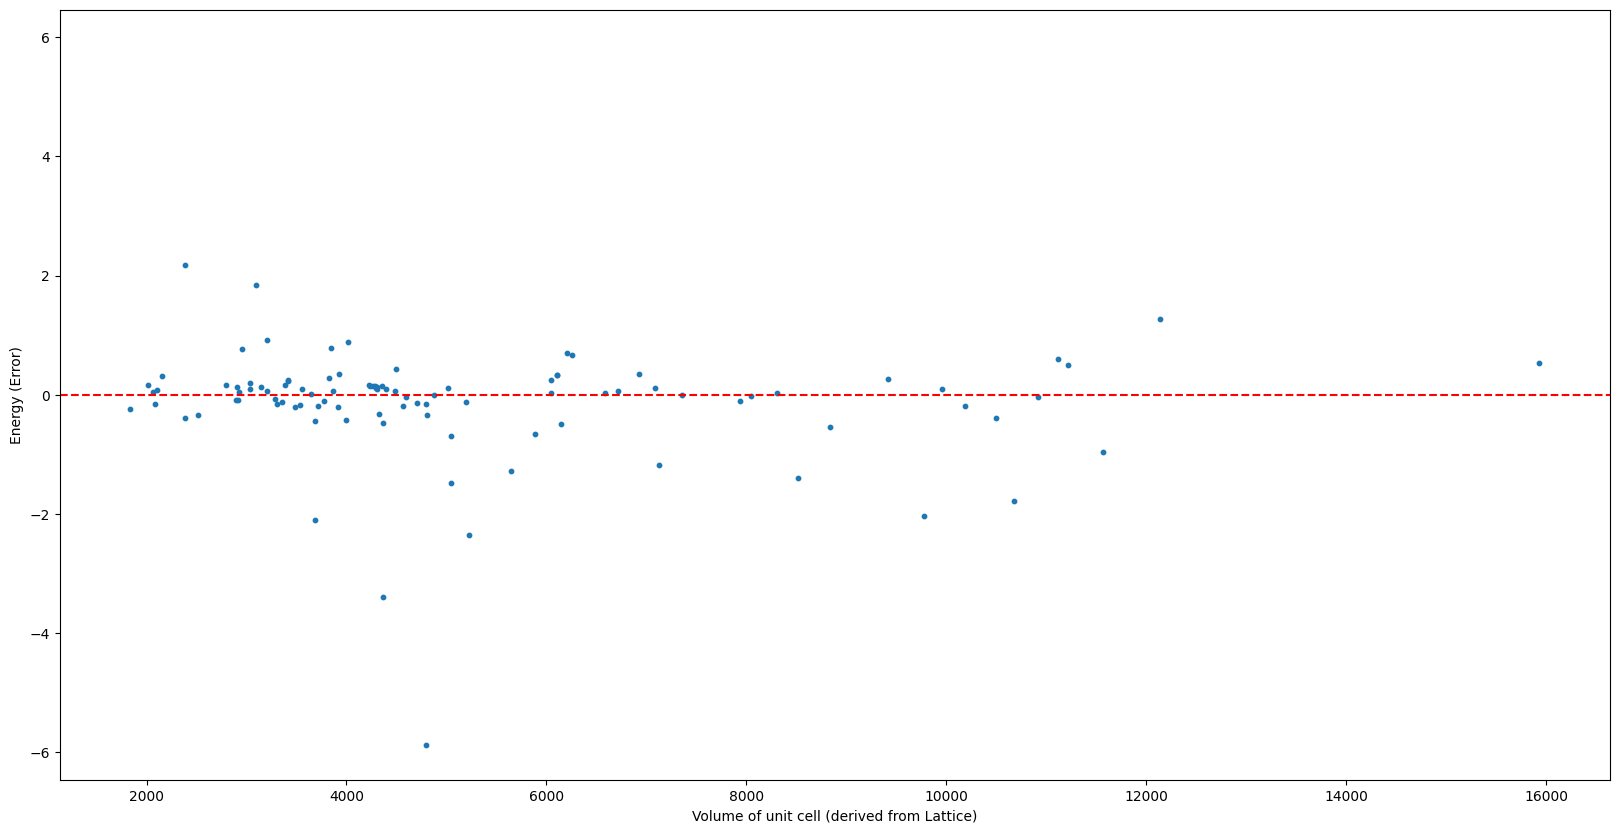

In [19]:
df_sorted = df.sort_values(by=["volume of unit cell (derived from Lattice)"])
plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
plt.xlabel("Volume of unit cell (derived from Lattice)")
plt.ylabel("Energy (Error)")
plt.ylim(-1.1*df["energy (error)"].abs().max(), 1.1*df["energy (error)"].abs().max())
plt.scatter(df_sorted["volume of unit cell (derived from Lattice)"], df_sorted['energy (error)'], s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Moving average

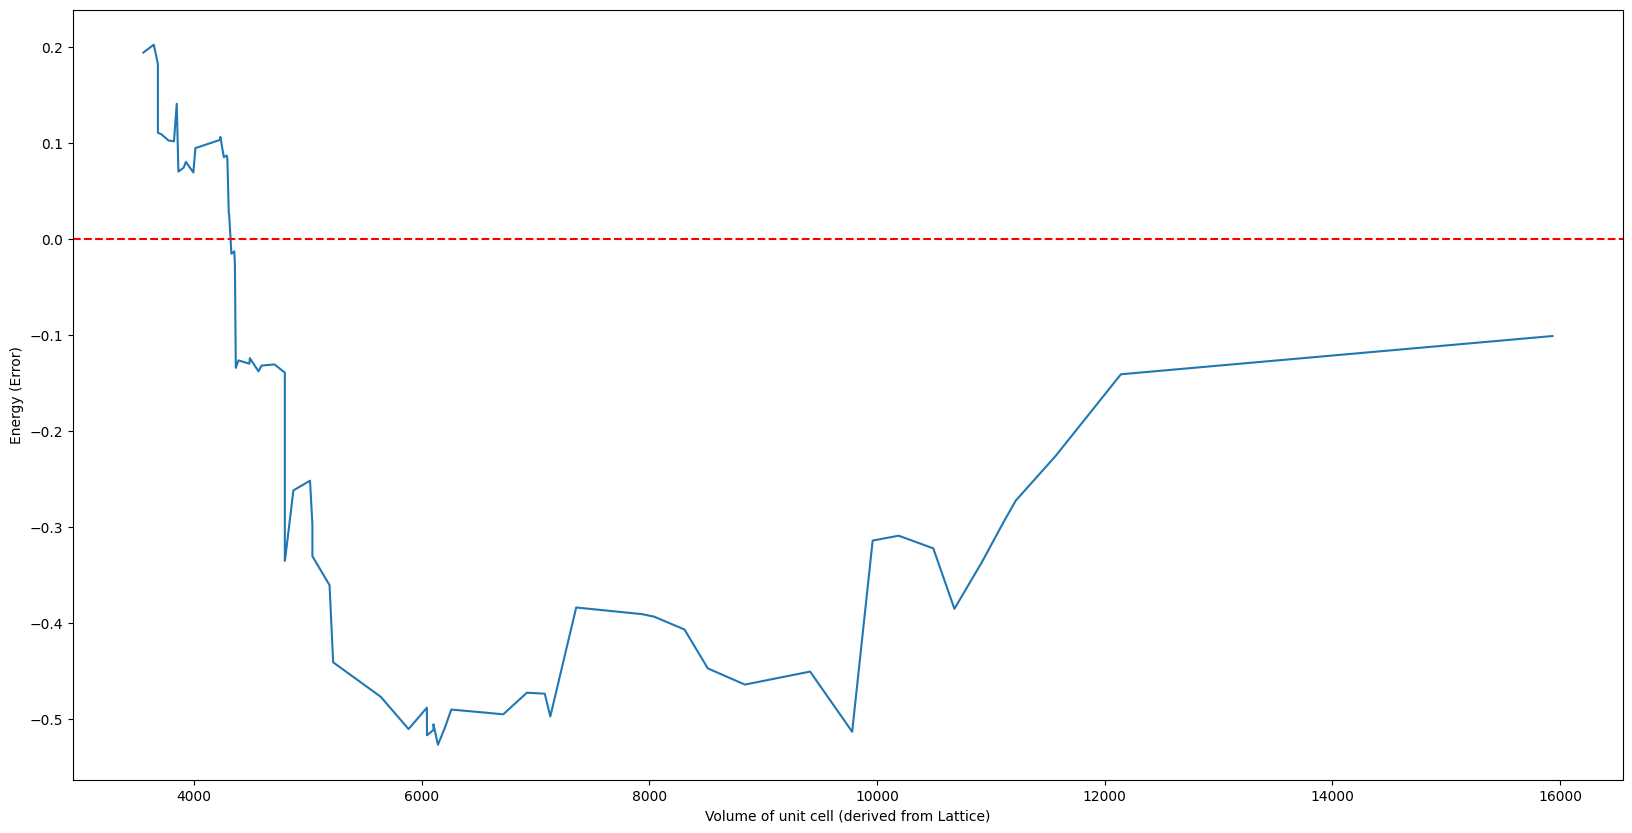

In [20]:
plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
plt.xlabel("Volume of unit cell (derived from Lattice)")
plt.ylabel("Energy (Error)")
#plt.ylim(-0.5*df["energy (error)"].abs().max(), 0.5*df["energy (error)"].abs().max())
plt.plot(df_sorted["volume of unit cell (derived from Lattice)"], df_sorted['energy (error)'].rolling(30).mean())
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Distribution of Error (abs) when Sorted by Element Present (Weighted and Unweighted by number of atoms)

In [21]:
element_list = ['H',
                                                                                                'B', 'C', 'N', 'O',
                'Na',                                                                           'Al', 'Si', 'P', 'S', 'Cl',
                'K', 'Ca',      'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',      'Ga', 'Ge', 'As', 'Se',
                'Rb', 'Sr',     'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',      'In', 'Sn', 'Sb', 'Te', 
                'Cs',           'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',            'Tl', 'Pb', 'Bi']

#extract list of elements
#element_list = []
#for i in range(len(df)):
#    element_list += dataset_list[i].get_chemical_symbols()
#    element_list = [*set(element_list)]

unweighted_mean_errors = []
weighted_errors = []
weighted_mean_errors = []
bar_colors = []
print("   Unweighted Error     Weighted Error        no. of unit cells it is present in")
for count, element in enumerate(element_list):    
    df_filtered = df[df['chemical formula'].str.contains(element)].reset_index(drop=True)

    #unweighted_mean_error = df_filtered["energy (error)"].abs().mean() # absolute value is used
    unweighted_mean_error = df_filtered["energy (error)"].mean()
    unweighted_mean_errors.append(unweighted_mean_error)

    for i in range(len(df_filtered)):
        number_of_element_atom = df_filtered["chemical formula"][i].split(element)[1][:2]
        number_of_element_atom = ''.join(char for char in number_of_element_atom if char.isdigit())
        if number_of_element_atom == "":
            number_of_element_atom = 1
        else:
            number_of_element_atom = int(number_of_element_atom)
        weight = number_of_element_atom/df_filtered["number of atoms"][i]
        #weighted_errors.append(df_filtered["energy (error)"].abs()[i] * weight) # absolute value is used
        weighted_errors.append(df_filtered["energy (error)"][i] * weight)
    weighted_mean_errors.append(np.mean(weighted_errors))

    if element == "H":
        bar_colors.append((1, 0, 0, 1))
    elif element == "C" or element == "N" or element == "O":
        bar_colors.append((1, 0, 1, len(df_filtered)/len(df[df['chemical formula'].str.contains("H")].reset_index(drop=True))))
    else:
        bar_colors.append((31/255, 119/255, 180/255, len(df_filtered)/len(df[df['chemical formula'].str.contains("S")].reset_index(drop=True))))

    print(f'{element}: {unweighted_mean_error}   {weighted_mean_errors[count]}    {len(df_filtered)}')

   Unweighted Error     Weighted Error        no. of unit cells it is present in
H: -0.1411124327660581   -0.0041239902855872085    89
B: 0.05117128629945   -0.004016733276399948    2
C: -0.1544539577010211   -0.003642842207829458    73
N: -0.11976332827148894   -0.013312448532169043    32
O: -0.15158198238934925   -0.010294391410651752    66
Na: -0.011758428513786612   -0.010422607789285866    2
Al: 0.16378631235016408   -0.00828628838893911    6
Si: -0.3520952909129467   -0.007800293018808941    3
P: 0.04314181205856649   -0.005662003523880744    16
S: -0.5694597391400537   -0.013904966614294873    35
Cl: nan   -0.013904966614294873    0
K: -0.26029177947319226   -0.014630507131628683    4
Ca: -0.4546600970740471   -0.01760056219160112    4
Sc: -0.045698793386103866   -0.017404327597776374    3
Ti: 0.10261407480831981   -0.01637436813459679    6
V: 0.012880782629042641   -0.01643388132544295    5
Cr: 0.05340885763916958   -0.016351890333240485    1
Mn: -0.12761021973680423   -0.01607

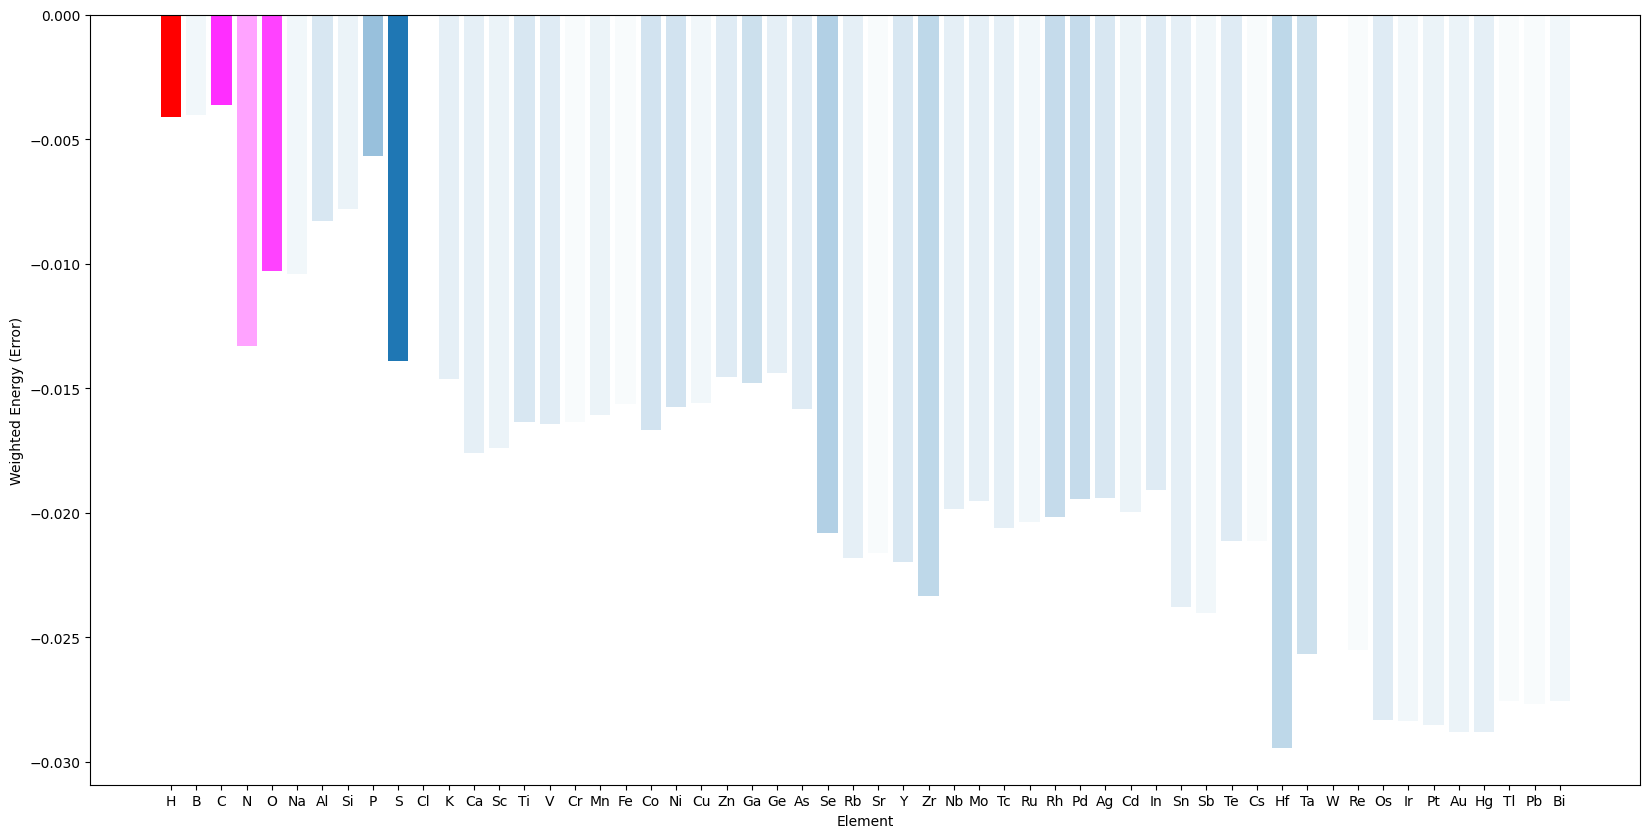

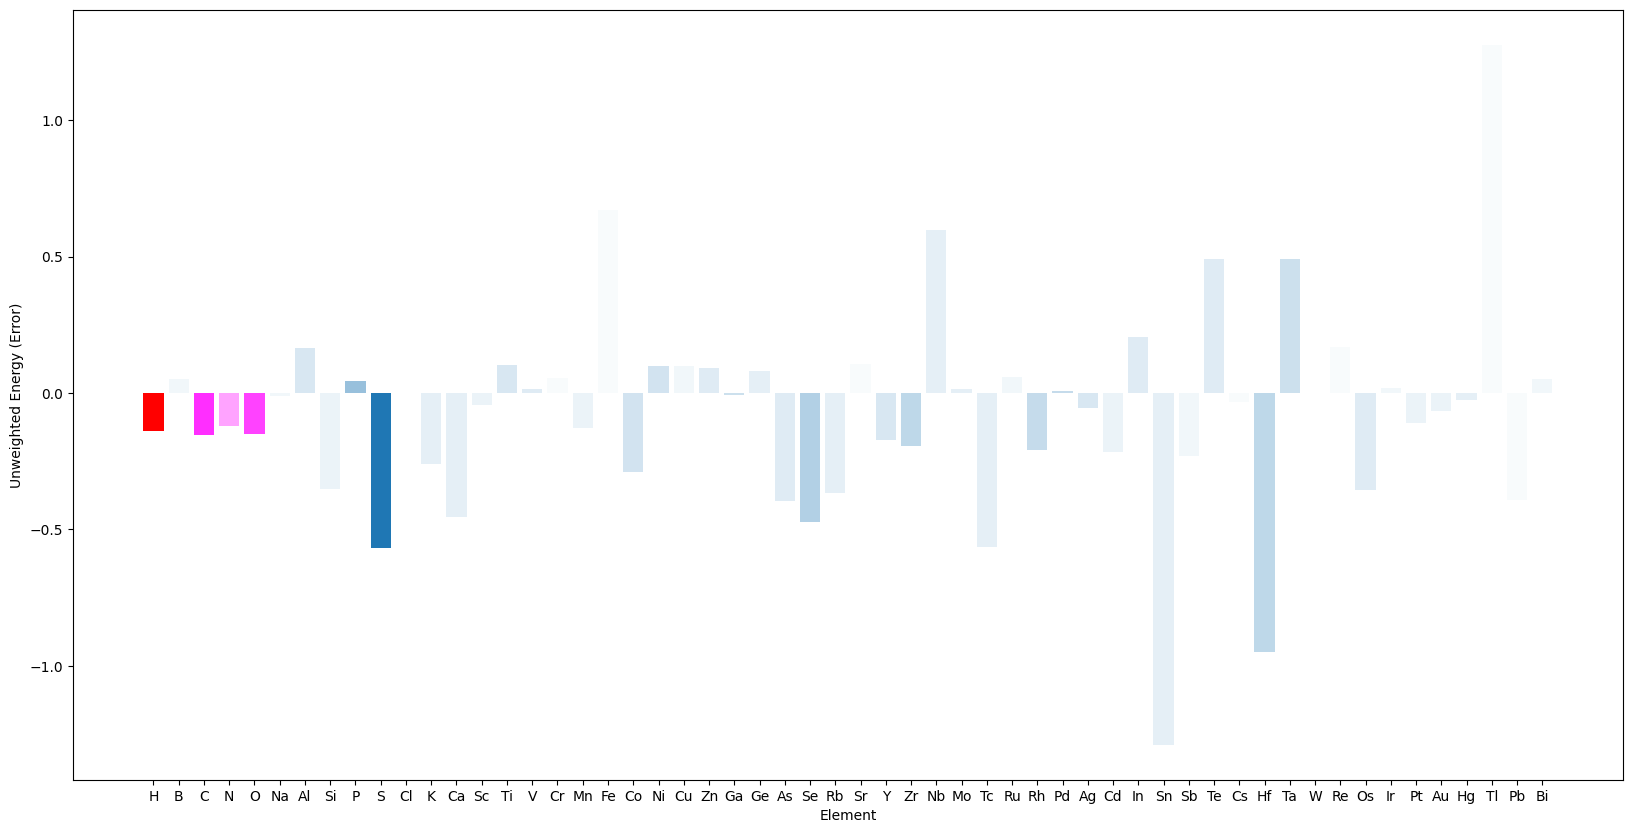

In [22]:
plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
plt.xlabel('Element')
plt.ylabel("Weighted Energy (Error)")
plt.bar(element_list, weighted_mean_errors, color=bar_colors)
plt.show()


plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
plt.xlabel('Element')
plt.ylabel("Unweighted Energy (Error)")
plt.bar(element_list, unweighted_mean_errors, color=bar_colors)
plt.show()

In [25]:
ptable_plotter(data_elements=element_list, data_list=unweighted_mean_errors)

In [24]:
ptable_plotter(data_elements=element_list, data_list=weighted_mean_errors)

# Distribution of Error (abs) when Sorted by adsorbate Present